# FASE 1: ANÁLISIS EXPLORATORIO INICIAL

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pymysql
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import DBSCAN
import logging

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("*")


*


## Cargar variables de entorno y conectar a BD

In [142]:
load_dotenv()

True

In [144]:
DATABASE_URL = os.getenv('DATABASE_URL')

def connect_to_database():
    """Establece conexión segura con la base de datos"""
    try:
        engine = create_engine(DATABASE_URL)
        with engine.connect() as conn:
            result = conn.execute(text("SELECT 1"))
            logger.info("Conexión a MySQL establecida exitosamente")
            return engine
    except Exception as e:
        logger.error(f"Error al conectar a la base de datos: {e}")
        return None

engine = connect_to_database()

2025-08-18 21:21:23,635 - INFO - Conexión a MySQL establecida exitosamente


#### Query principal para cargar todos los datos

In [146]:
def load_cardiac_data(limit=None):
    """Carga datos de mediciones cardíacas con opción de límite"""
    
    base_query = """
    SELECT 
        ID,
        Usuario_ID,
        Smartwatch_ID,
        Timestamp_medicion,
        Frecuencia_cardiaca,
        Presion_sistolica,
        Presion_diastolica,
        Saturacion_oxigeno,
        Temperatura,
        Nivel_estres,
        Variabilidad_ritmo,
        Estatus,
        Fecha_Registro,
        Fecha_Actualizacion
    FROM tbb_mediciones_cardiacas
    ORDER BY Usuario_ID, Timestamp_medicion
    """
    
    if limit:
        query = base_query + f" LIMIT {limit};"
    else:
        query = base_query + ";"
    
    try:
        df = pd.read_sql_query(query, engine)
        logger.info(f"Datos cargados: {df.shape[0]} registros, {df.shape[1]} columnas")
        return df
    except Exception as e:
        logger.error(f"Error al cargar datos: {e}")
        return None

In [148]:
df_raw = load_cardiac_data()

2025-08-18 21:21:29,890 - INFO - Datos cargados: 50137 registros, 14 columnas


## INFORMACIÓN GENERAL DEL DATASET ORIGINAL

In [150]:
print(f"Dimensiones: {df_raw.shape[0]:,} filas × {df_raw.shape[1]} columnas")
print(f"Memoria utilizada: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Dimensiones: 50,137 filas × 14 columnas
Memoria utilizada: 6.12 MB


In [152]:
# Información sobre usuarios
print(f"\nINFORMACIÓN DE USUARIOS:")
print(f"   • Usuarios únicos: {df_raw['Usuario_ID'].nunique():,}")
print(f"   • Dispositivos únicos: {df_raw['Smartwatch_ID'].nunique():,}")


INFORMACIÓN DE USUARIOS:
   • Usuarios únicos: 100
   • Dispositivos únicos: 100


In [154]:
# Estadísticas por usuario
user_stats = df_raw.groupby('Usuario_ID').agg({
    'ID': 'count',
    'Timestamp_medicion': ['min', 'max'],
    'Smartwatch_ID': 'nunique'
})

In [156]:
# Aplanar las columnas MultiIndex correctamente
user_stats.columns = ['Total_Mediciones', 'Primera_Medicion', 'Ultima_Medicion', 'Dispositivos_Usados']

# Calcular días monitoreados y mediciones por día
user_stats['Dias_Monitoreados'] = (pd.to_datetime(user_stats['Ultima_Medicion']) - 
                                   pd.to_datetime(user_stats['Primera_Medicion'])).dt.days + 1
user_stats['Mediciones_Por_Dia'] = (user_stats['Total_Mediciones'] / 
                                   user_stats['Dias_Monitoreados']).round(2)

print(f"\n📊 ESTADÍSTICAS POR USUARIO:")
print(f"   • Promedio de mediciones por usuario: {user_stats['Total_Mediciones'].mean():.1f}")
print(f"   • Mediana de mediciones por usuario: {user_stats['Total_Mediciones'].median():.1f}")
print(f"   • Usuario con más mediciones: {user_stats['Total_Mediciones'].max():,}")
print(f"   • Usuario con menos mediciones: {user_stats['Total_Mediciones'].min():,}")


📊 ESTADÍSTICAS POR USUARIO:
   • Promedio de mediciones por usuario: 501.4
   • Mediana de mediciones por usuario: 451.5
   • Usuario con más mediciones: 931
   • Usuario con menos mediciones: 229


In [158]:
# Mostrar estadísticas de los top 10 usuarios
print(f"\n🔝 TOP 10 USUARIOS CON MÁS MEDICIONES:")
top_users_stats = user_stats.nlargest(10, 'Total_Mediciones')[
    ['Total_Mediciones', 'Dias_Monitoreados', 'Mediciones_Por_Dia', 'Dispositivos_Usados']
]
display(top_users_stats)


🔝 TOP 10 USUARIOS CON MÁS MEDICIONES:


,Total_Mediciones,Dias_Monitoreados,Mediciones_Por_Dia,Dispositivos_Usados
Usuario_ID,,,,
95,931,31,30.030,1
99,916,31,29.550,1
27,904,31,29.160,1
61,895,31,28.870,1
13,894,31,28.840,1
49,658,31,21.230,1
50,654,31,21.100,1
74,643,31,20.740,1
21,642,31,20.710,1


In [160]:
# Mostrar muestra de datos raw
print(f"\nMUESTRA DE DATOS ORIGINALES:")
display(df_raw.head())



MUESTRA DE DATOS ORIGINALES:


,ID,Usuario_ID,Smartwatch_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Estatus,Fecha_Registro,Fecha_Actualizacion
0,8,1,1,2025-07-19 05:24:11,57,94.000,60.000,98.800,36.700,2,34.440,1,2025-08-18 20:35:27,None
1,9,1,1,2025-07-19 06:47:01,66,93.000,60.000,98.100,36.100,20,21.650,1,2025-08-18 20:35:27,None
2,4,1,1,2025-07-19 07:01:25,60,100.000,60.000,98.300,36.500,11,40.210,1,2025-08-18 20:35:27,None
3,10,1,1,2025-07-19 07:31:22,87,NaN,NaN,97.400,NaN,12,53.710,1,2025-08-18 20:35:27,None
4,5,1,1,2025-07-19 09:18:27,96,92.000,60.000,98.800,37.100,2,39.270,1,2025-08-18 20:35:27,None


# Fase 2: Análisis de Estructura y Calidad Inicial

In [166]:
#### Función Principal de Análisis

In [162]:
print("=" * 60)
print("🔍 ANÁLISIS DE CALIDAD DE DATOS")
print("=" * 60)

# Información general de tipos y nulos
info_df = pd.DataFrame({
    'Columna': df_raw.columns,
    'Tipo_Dato': df_raw.dtypes,
    'Valores_No_Nulos': df_raw.count(),
    'Valores_Nulos': df_raw.isnull().sum(),
    'Porcentaje_Nulos': (df_raw.isnull().sum() / len(df_raw) * 100).round(2),
    'Valores_Unicos': [df_raw[col].nunique() for col in df_raw.columns],
    'Porcentaje_Unicos': [round((df_raw[col].nunique() / len(df_raw) * 100), 2) for col in df_raw.columns]
})

display(info_df)

🔍 ANÁLISIS DE CALIDAD DE DATOS


,Columna,Tipo_Dato,Valores_No_Nulos,Valores_Nulos,Porcentaje_Nulos,Valores_Unicos,Porcentaje_Unicos
ID,ID,int64,50137,0,0.000,50137,100.000
Usuario_ID,Usuario_ID,int64,50137,0,0.000,100,0.200
Smartwatch_ID,Smartwatch_ID,int64,50137,0,0.000,100,0.200
Timestamp_medicion,Timestamp_medicion,datetime64[ns],50137,0,0.000,49628,98.980
Frecuencia_cardiaca,Frecuencia_cardiaca,int64,50137,0,0.000,117,0.230
Presion_sistolica,Presion_sistolica,float64,45106,5031,10.030,123,0.250
Presion_diastolica,Presion_diastolica,float64,45106,5031,10.030,50,0.100
Saturacion_oxigeno,Saturacion_oxigeno,float64,47483,2654,5.290,109,0.220
Temperatura,Temperatura,float64,39931,10206,20.360,35,0.070
Nivel_estres,Nivel_estres,int64,50137,0,0.000,93,0.190


In [164]:
# 2. ANÁLISIS DE DUPLICADOS BÁSICO
duplicates = {
    'completos': df_raw.duplicated().sum(),
    'por_usuario_timestamp': df_raw.duplicated(subset=['Usuario_ID', 'Timestamp_medicion']).sum(),
    'por_todas_mediciones': df_raw.duplicated(subset=[
        'Usuario_ID', 'Timestamp_medicion', 'Frecuencia_cardiaca', 
        'Presion_sistolica', 'Presion_diastolica'
    ]).sum()
}

print(f"\n🔍 ANÁLISIS DE DUPLICADOS:")
for tipo, cantidad in duplicates.items():
    print(f"   • {tipo.replace('_', ' ').title()}: {cantidad:,} ({cantidad/len(df_raw)*100:.2f}%)")


🔍 ANÁLISIS DE DUPLICADOS:
   • Completos: 0 (0.00%)
   • Por Usuario Timestamp: 2 (0.00%)
   • Por Todas Mediciones: 0 (0.00%)


In [166]:
# 3. IDENTIFICAR USUARIOS CON DUPLICADOS
users_with_duplicates = df_raw[df_raw.duplicated(subset=['Usuario_ID', 'Timestamp_medicion'])]['Usuario_ID'].unique()

print(f"\n👥 ANÁLISIS POR USUARIO:")
print(f"   • Usuarios con mediciones duplicadas: {len(users_with_duplicates):,}")

if len(users_with_duplicates) > 0:
    print("   • Top 5 usuarios con más duplicados:")
    user_duplicate_counts = df_raw[df_raw.duplicated(subset=['Usuario_ID', 'Timestamp_medicion'], keep=False)].groupby('Usuario_ID').size().sort_values(ascending=False)
    for user_id, count in user_duplicate_counts.head().items():
        print(f"     - Usuario {user_id}: {count} mediciones duplicadas")


# 4. MOSTRAR CASOS DUPLICADOS ESPECÍFICOS
print(f"\n📋 CASOS DUPLICADOS ESPECÍFICOS:")
duplicated_cases = df_raw[df_raw.duplicated(subset=['Usuario_ID', 'Timestamp_medicion'], keep=False)].sort_values(['Usuario_ID', 'Timestamp_medicion'])

if len(duplicated_cases) > 0:
    print("Registros con mismo Usuario_ID y Timestamp_medicion:")
    
    # Seleccionar columnas más relevantes para mostrar
    cols_to_show = ['ID', 'Usuario_ID', 'Timestamp_medicion', 'Frecuencia_cardiaca', 
                   'Presion_sistolica', 'Presion_diastolica', 'Smartwatch_ID', 'Fecha_Registro']
    
    # Filtrar columnas que existan en el DataFrame
    cols_available = [col for col in cols_to_show if col in df_raw.columns]
    
    display(duplicated_cases[cols_available])
else:
    print("No se encontraron casos duplicados por Usuario_ID y Timestamp_medicion")


👥 ANÁLISIS POR USUARIO:
   • Usuarios con mediciones duplicadas: 2
   • Top 5 usuarios con más duplicados:
     - Usuario 58: 2 mediciones duplicadas
     - Usuario 67: 2 mediciones duplicadas

📋 CASOS DUPLICADOS ESPECÍFICOS:
Registros con mismo Usuario_ID y Timestamp_medicion:


,ID,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Smartwatch_ID,Fecha_Registro
28316,28313,58,2025-08-01 12:23:41,79,156.000,99.000,58,2025-08-18 20:35:27
28317,28323,58,2025-08-01 12:23:41,100,152.000,99.000,58,2025-08-18 20:35:27
33227,33228,67,2025-08-03 07:45:39,84,116.000,80.000,67,2025-08-18 20:35:27
33228,33233,67,2025-08-03 07:45:39,71,100.000,63.000,67,2025-08-18 20:35:27


# Fase 3: Limpieza y Transformación

In [168]:
# LIMPIEZA Y TRANSFORMACIÓN

print("=" * 80)
print("PROCESO DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

# Crear copia para limpieza
df_clean = df_raw.copy()
initial_rows = len(df_clean)

print(f"Iniciando limpieza con {initial_rows:,} registros")

PROCESO DE LIMPIEZA Y TRANSFORMACIÓN
Iniciando limpieza con 50,137 registros


In [170]:
print("\n🔄 LIMPIEZA DE DUPLICADOS:")
initial_count = len(df_clean)
print(f"   • Registros iniciales: {initial_count:,}")

# 1. Eliminar duplicados completos (si los hay)
df_clean = df_clean.drop_duplicates()
after_complete_dups = len(df_clean)
complete_dups_removed = initial_count - after_complete_dups
print(f"   • Duplicados completos eliminados: {complete_dups_removed:,}")

# 2. Para mismo usuario y timestamp, mantener el más reciente por Fecha_Registro
df_clean = df_clean.sort_values('Fecha_Registro').drop_duplicates(
    subset=['Usuario_ID', 'Timestamp_medicion'], keep='last'
)

final_count = len(df_clean)
user_time_dups_removed = after_complete_dups - final_count
print(f"   • Duplicados por usuario-timestamp eliminados: {user_time_dups_removed:,}")

total_removed = initial_count - final_count
print(f"   • Total registros eliminados: {total_removed:,} ({total_removed/initial_count*100:.2f}%)")
print(f"   • Registros restantes: {final_count:,}")


🔄 LIMPIEZA DE DUPLICADOS:
   • Registros iniciales: 50,137
   • Duplicados completos eliminados: 0
   • Duplicados por usuario-timestamp eliminados: 2
   • Total registros eliminados: 2 (0.00%)
   • Registros restantes: 50,135


In [172]:
# %%
print("🔍 ANÁLISIS DE ELIMINACIÓN POR VALORES NULOS")
print("=" * 60)

# Variables críticas que requieren valores completos
critical_vars = ['Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 
                'Temperatura', 'Variabilidad_ritmo']

print(f"Variables críticas que requieren datos completos: {critical_vars}")

# Identificar filas con al menos un nulo en variables críticas
mask_with_nulls = df_clean[critical_vars].isnull().any(axis=1)
rows_to_delete = df_clean[mask_with_nulls]
rows_to_keep = df_clean[~mask_with_nulls]

print(f"\n📊 IMPACTO GENERAL:")
print(f"   • Total registros actuales: {len(df_clean):,}")
print(f"   • Registros a eliminar: {len(rows_to_delete):,} ({len(rows_to_delete)/len(df_clean)*100:.2f}%)")
print(f"   • Registros que permanecen: {len(rows_to_keep):,} ({len(rows_to_keep)/len(df_clean)*100:.2f}%)")

🔍 ANÁLISIS DE ELIMINACIÓN POR VALORES NULOS
Variables críticas que requieren datos completos: ['Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 'Temperatura', 'Variabilidad_ritmo']

📊 IMPACTO GENERAL:
   • Total registros actuales: 50,135
   • Registros a eliminar: 16,780 (33.47%)
   • Registros que permanecen: 33,355 (66.53%)


In [174]:
# %%
print("🗑️ ELIMINANDO REGISTROS CON VALORES NULOS")
print("=" * 60)

# Variables críticas que requieren valores completos
critical_vars = ['Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 
                'Temperatura', 'Variabilidad_ritmo']

print(f"Variables críticas: {critical_vars}")

# Guardar estadísticas antes de eliminar
initial_total = len(df_clean)
initial_users = df_clean['Usuario_ID'].nunique()

# Identificar filas con al menos un nulo en variables críticas
mask_with_nulls = df_clean[critical_vars].isnull().any(axis=1)
rows_to_delete_count = mask_with_nulls.sum()

# Estadísticas por usuario ANTES de eliminar
print("\n📊 ESTADÍSTICAS ANTES DE ELIMINAR:")
user_stats_before = df_clean.groupby('Usuario_ID').size().reset_index(name='Registros_Antes')
print(f"   • Total registros: {initial_total:,}")
print(f"   • Usuarios únicos: {initial_users:,}")
print(f"   • Registros a eliminar: {rows_to_delete_count:,}")

# ELIMINAR registros con nulos
df_clean = df_clean[~mask_with_nulls].reset_index(drop=True)

# Estadísticas después de eliminar
final_total = len(df_clean)
final_users = df_clean['Usuario_ID'].nunique()
total_eliminated = initial_total - final_total
users_lost = initial_users - final_users

print(f"\n✅ ELIMINACIÓN COMPLETADA:")
print(f"   • Registros eliminados: {total_eliminated:,}")
print(f"   • Registros restantes: {final_total:,}")
print(f"   • Porcentaje eliminado: {(total_eliminated/initial_total)*100:.2f}%")
print(f"   • Usuarios perdidos completamente: {users_lost:,}")
print(f"   • Usuarios restantes: {final_users:,}")

🗑️ ELIMINANDO REGISTROS CON VALORES NULOS
Variables críticas: ['Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 'Temperatura', 'Variabilidad_ritmo']

📊 ESTADÍSTICAS ANTES DE ELIMINAR:
   • Total registros: 50,135
   • Usuarios únicos: 100
   • Registros a eliminar: 16,780

✅ ELIMINACIÓN COMPLETADA:
   • Registros eliminados: 16,780
   • Registros restantes: 33,355
   • Porcentaje eliminado: 33.47%
   • Usuarios perdidos completamente: 0
   • Usuarios restantes: 100


In [176]:
# %%
print(f"\n ESTADÍSTICAS FINALES POR USUARIO:")
print("=" * 50)

# Estadísticas por usuario DESPUÉS de eliminar
user_stats_after = df_clean.groupby('Usuario_ID').size().reset_index(name='Registros_Despues')

# Combinar estadísticas antes y después
user_comparison = user_stats_before.merge(user_stats_after, on='Usuario_ID', how='left')
user_comparison['Registros_Despues'] = user_comparison['Registros_Despues'].fillna(0).astype(int)
user_comparison['Registros_Eliminados'] = user_comparison['Registros_Antes'] - user_comparison['Registros_Despues']
user_comparison['Porcentaje_Eliminado'] = (user_comparison['Registros_Eliminados'] / user_comparison['Registros_Antes'] * 100).round(2)
user_comparison['Estado'] = user_comparison['Registros_Despues'].apply(
    lambda x: 'ELIMINADO COMPLETO' if x == 0 else 'PARCIAL'
)

# Ordenar por registros restantes (descendente)
user_comparison = user_comparison.sort_values('Registros_Despues', ascending=False)

print(f"Resumen por usuario (Top 20 con más datos restantes):")
display(user_comparison.head(20)[['Usuario_ID', 'Registros_Antes', 'Registros_Despues', 
                                 'Registros_Eliminados', 'Porcentaje_Eliminado', 'Estado']])

# Usuarios completamente eliminados
users_eliminated = user_comparison[user_comparison['Registros_Despues'] == 0]
if len(users_eliminated) > 0:
    print(f"\n⚠️  USUARIOS COMPLETAMENTE ELIMINADOS ({len(users_eliminated):,}):")
    print(f"IDs: {users_eliminated['Usuario_ID'].tolist()}")


 ESTADÍSTICAS FINALES POR USUARIO:
Resumen por usuario (Top 20 con más datos restantes):


,Usuario_ID,Registros_Antes,Registros_Despues,Registros_Eliminados,Porcentaje_Eliminado,Estado
60,61,895,627,268,29.940,PARCIAL
26,27,904,613,291,32.190,PARCIAL
98,99,916,611,305,33.300,PARCIAL
94,95,931,610,321,34.480,PARCIAL
12,13,894,595,299,33.450,PARCIAL
91,92,641,443,198,30.890,PARCIAL
48,49,658,440,218,33.130,PARCIAL
92,93,633,430,203,32.070,PARCIAL
4,5,630,430,200,31.750,PARCIAL
70,71,627,424,203,32.380,PARCIAL


In [178]:
# %%
print(f"\n📈 RESUMEN ESTADÍSTICO FINAL:")
print("=" * 40)

print(f"REGISTROS:")
print(f"   • Inicial: {initial_total:,}")
print(f"   • Final: {final_total:,}")
print(f"   • Eliminados: {total_eliminated:,} ({(total_eliminated/initial_total)*100:.2f}%)")

print(f"\nUSUARIOS:")
print(f"   • Inicial: {initial_users:,}")
print(f"   • Final: {final_users:,}")
print(f"   • Perdidos completamente: {users_lost:,}")

if final_users > 0:
    avg_records_per_user = final_total / final_users
    print(f"\nPROMEDIOS POR USUARIO RESTANTE:")
    print(f"   • Promedio registros por usuario: {avg_records_per_user:.1f}")
    
    remaining_user_stats = user_comparison[user_comparison['Registros_Despues'] > 0]['Registros_Despues']
    print(f"\nDISTRIBUCIÓN DE REGISTROS POR USUARIO:")
    print(f"   • Mínimo: {remaining_user_stats.min():,} registros")
    print(f"   • Máximo: {remaining_user_stats.max():,} registros")
    print(f"   • Mediana: {remaining_user_stats.median():.0f} registros")

remaining_nulls = df_clean[critical_vars].isnull().sum().sum()
print(f"\n✅ DATASET LIMPIO LISTO PARA SIGUIENTE FASE")
print(f"   • Valores nulos restantes en variables críticas: {remaining_nulls}")

# 📊 VISUALIZACIONES
print(f"\n" + "="*60)
print("📊 VISUALIZACIONES DEL IMPACTO DE LIMPIEZA")
print("="*60)


📈 RESUMEN ESTADÍSTICO FINAL:
REGISTROS:
   • Inicial: 50,135
   • Final: 33,355
   • Eliminados: 16,780 (33.47%)

USUARIOS:
   • Inicial: 100
   • Final: 100
   • Perdidos completamente: 0

PROMEDIOS POR USUARIO RESTANTE:
   • Promedio registros por usuario: 333.6

DISTRIBUCIÓN DE REGISTROS POR USUARIO:
   • Mínimo: 141 registros
   • Máximo: 627 registros
   • Mediana: 301 registros

✅ DATASET LIMPIO LISTO PARA SIGUIENTE FASE
   • Valores nulos restantes en variables críticas: 0

📊 VISUALIZACIONES DEL IMPACTO DE LIMPIEZA


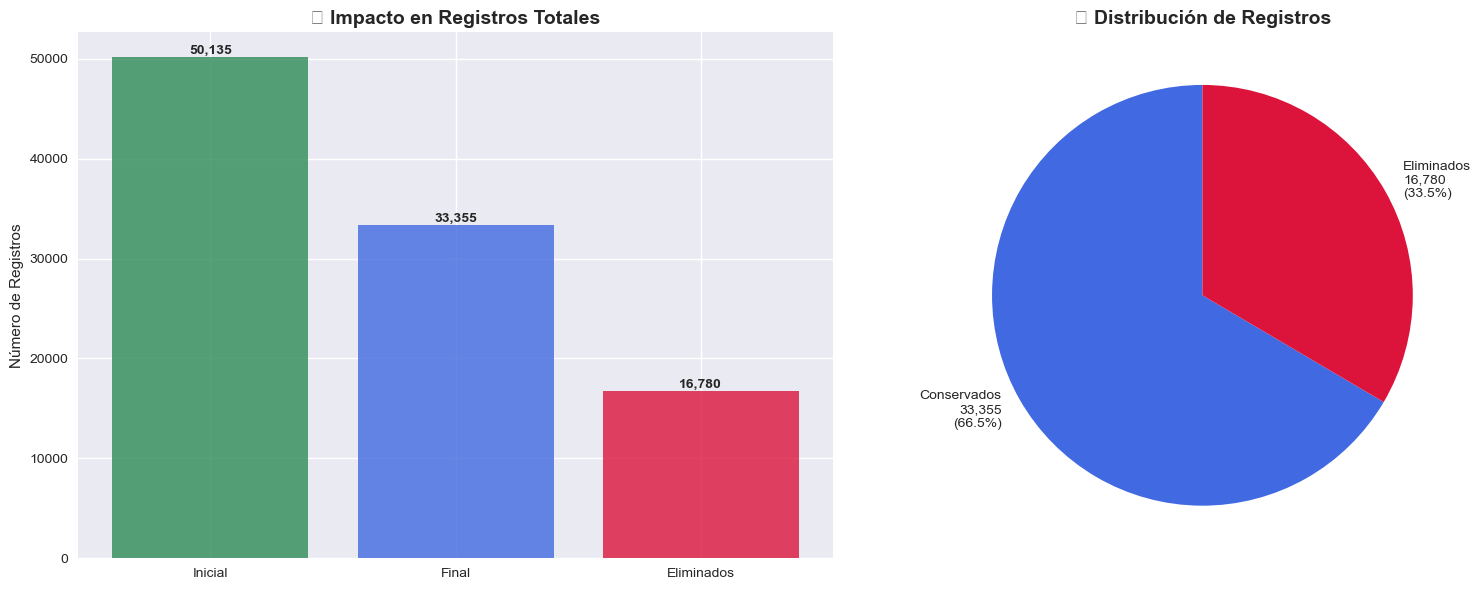

In [180]:
# %%
# GRÁFICOS COMPARATIVOS - REGISTROS Y USUARIOS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. GRÁFICO DE BARRAS COMPARATIVO - REGISTROS
records_data = ['Inicial', 'Final', 'Eliminados']
records_values = [initial_total, final_total, total_eliminated]
colors_records = ['#2E8B57', '#4169E1', '#DC143C']

bars1 = ax1.bar(records_data, records_values, color=colors_records, alpha=0.8)
ax1.set_title('📊 Impacto en Registros Totales', fontsize=14, fontweight='bold')
ax1.set_ylabel('Número de Registros')

# Agregar valores encima de las barras
for bar, value in zip(bars1, records_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# 2. GRÁFICO DE PIE - PORCENTAJE DE REGISTROS
records_pie_data = [final_total, total_eliminated]
records_pie_labels = [f'Conservados\n{final_total:,}\n({(final_total/initial_total)*100:.1f}%)', 
                     f'Eliminados\n{total_eliminated:,}\n({(total_eliminated/initial_total)*100:.1f}%)']

wedges, texts, autotexts = ax2.pie(records_pie_data, labels=records_pie_labels, 
                                  colors=['#4169E1', '#DC143C'], autopct='',
                                  startangle=90, textprops={'fontsize': 10})

ax2.set_title('📈 Distribución de Registros', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [182]:
# %%
# Resumen simple del dataset limpio
print(f" DATASET LIMPIO FINAL:")
print(f"   • Nombre: df_clean")
print(f"   • Total registros: {len(df_clean):,}")
print(f"   • Total usuarios: {df_clean['Usuario_ID'].nunique():,}")
print(f"   • Total columnas: {df_clean.shape[1]}")

# Muestra de los datos limpios
print(f"\n📋 MUESTRA DE DATOS LIMPIOS:")
display(df_clean.head(10))

 DATASET LIMPIO FINAL:
   • Nombre: df_clean
   • Total registros: 33,355
   • Total usuarios: 100
   • Total columnas: 14

📋 MUESTRA DE DATOS LIMPIOS:


,ID,Usuario_ID,Smartwatch_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Estatus,Fecha_Registro,Fecha_Actualizacion
0,8,1,1,2025-07-19 05:24:11,57,94.000,60.000,98.800,36.700,2,34.440,1,2025-08-18 20:35:27,None
1,25372,52,52,2025-07-31 09:02:07,105,123.000,85.000,97.000,36.800,29,27.740,1,2025-08-18 20:35:27,None
2,25376,52,52,2025-07-31 13:54:42,86,132.000,87.000,96.600,36.700,17,11.910,1,2025-08-18 20:35:27,None
3,25365,52,52,2025-07-31 13:56:03,88,119.000,83.000,97.900,36.900,28,18.470,1,2025-08-18 20:35:27,None
4,25375,52,52,2025-07-31 20:23:58,88,116.000,77.000,97.600,36.800,20,21.920,1,2025-08-18 20:35:27,None
5,25374,52,52,2025-07-31 18:47:33,93,138.000,87.000,98.200,36.200,18,20.100,1,2025-08-18 20:35:27,None
6,25367,52,52,2025-07-31 07:29:55,74,114.000,75.000,99.400,37.000,22,16.960,1,2025-08-18 20:35:27,None
7,25368,52,52,2025-07-31 06:15:51,78,109.000,70.000,97.700,36.300,14,23.640,1,2025-08-18 20:35:27,None
8,25345,52,52,2025-07-29 20:03:43,81,122.000,86.000,99.500,37.000,12,18.830,1,2025-08-18 20:35:27,None
9,25348,52,52,2025-07-30 06:25:58,76,112.000,73.000,97.800,36.400,36,23.790,1,2025-08-18 20:35:27,None


In [184]:
print(f"\n INFO BÁSICA:")
df_clean.info()


 INFO BÁSICA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33355 entries, 0 to 33354
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   33355 non-null  int64         
 1   Usuario_ID           33355 non-null  int64         
 2   Smartwatch_ID        33355 non-null  int64         
 3   Timestamp_medicion   33355 non-null  datetime64[ns]
 4   Frecuencia_cardiaca  33355 non-null  int64         
 5   Presion_sistolica    33355 non-null  float64       
 6   Presion_diastolica   33355 non-null  float64       
 7   Saturacion_oxigeno   33355 non-null  float64       
 8   Temperatura          33355 non-null  float64       
 9   Nivel_estres         33355 non-null  int64         
 10  Variabilidad_ritmo   33355 non-null  float64       
 11  Estatus              33355 non-null  int64         
 12  Fecha_Registro       33355 non-null  datetime64[ns]
 13  Fecha_Actualizac

In [186]:
columnas_necesarias = [
    'ID', 'Usuario_ID', 'Timestamp_medicion', 'Frecuencia_cardiaca', 
    'Presion_sistolica', 'Presion_diastolica', 'Saturacion_oxigeno', 
    'Temperatura', 'Nivel_estres', 'Variabilidad_ritmo', 'Fecha_Registro'
]

df_clean = df_clean[columnas_necesarias]

print(f" DATASET FINAL:")
print(f"   • Registros: {len(df_clean):,}")
print(f"   • Columnas: {df_clean.shape[1]}")
print(f"   • Usuarios: {df_clean['Usuario_ID'].nunique():,}")

print(f"\n INFO FINAL:")
df_clean.info()

print(f"\n MUESTRA:")
display(df_clean.head())

 DATASET FINAL:
   • Registros: 33,355
   • Columnas: 11
   • Usuarios: 100

 INFO FINAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33355 entries, 0 to 33354
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   33355 non-null  int64         
 1   Usuario_ID           33355 non-null  int64         
 2   Timestamp_medicion   33355 non-null  datetime64[ns]
 3   Frecuencia_cardiaca  33355 non-null  int64         
 4   Presion_sistolica    33355 non-null  float64       
 5   Presion_diastolica   33355 non-null  float64       
 6   Saturacion_oxigeno   33355 non-null  float64       
 7   Temperatura          33355 non-null  float64       
 8   Nivel_estres         33355 non-null  int64         
 9   Variabilidad_ritmo   33355 non-null  float64       
 10  Fecha_Registro       33355 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(4)
memory usage

,ID,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Fecha_Registro
0,8,1,2025-07-19 05:24:11,57,94.000,60.000,98.800,36.700,2,34.440,2025-08-18 20:35:27
1,25372,52,2025-07-31 09:02:07,105,123.000,85.000,97.000,36.800,29,27.740,2025-08-18 20:35:27
2,25376,52,2025-07-31 13:54:42,86,132.000,87.000,96.600,36.700,17,11.910,2025-08-18 20:35:27
3,25365,52,2025-07-31 13:56:03,88,119.000,83.000,97.900,36.900,28,18.470,2025-08-18 20:35:27
4,25375,52,2025-07-31 20:23:58,88,116.000,77.000,97.600,36.800,20,21.920,2025-08-18 20:35:27


# ANÁLISIS MÉDICO POR USUARIO

In [188]:
# %%
print("🏥 FILTRADO DE VALORES MÉDICAMENTE IMPOSIBLES")
print("=" * 60)

# Rangos médicamente compatibles con la vida (estrictos)
rangos_vitales = {
    'Frecuencia_cardiaca': (25, 250),      # 25: bradicardia extrema, 250: taquicardia máxima
    'Presion_sistolica': (50, 300),        # 50: hipotensión severa, 300: crisis hipertensiva
    'Presion_diastolica': (20, 200),       # 20: hipotensión extrema, 200: hipertensión maligna
    'Saturacion_oxigeno': (50, 100),       # 50: hipoxemia severa límite, 100: máximo posible
    'Temperatura': (28.0, 44.0),           # 28°C: hipotermia severa, 44°C: hipertermia crítica
    'Nivel_estres': (0, 10),               # Escala estándar 0-10
    'Variabilidad_ritmo': (1, 300)         # 1: mínima variabilidad, 300: máxima registrada
}

print("Rangos de supervivencia definidos:")
for variable, (min_val, max_val) in rangos_vitales.items():
    print(f"   • {variable}: {min_val} - {max_val}")

# Contar registros fuera de rangos de supervivencia
registros_iniciales = len(df_clean)
print(f"\n📊 ANÁLISIS DE REGISTROS FUERA DE RANGOS DE SUPERVIVENCIA:")

registros_a_eliminar = pd.Series([False] * len(df_clean))

for variable, (min_val, max_val) in rangos_vitales.items():
    if variable in df_clean.columns:
        fuera_rango = (df_clean[variable] < min_val) | (df_clean[variable] > max_val)
        count_fuera = fuera_rango.sum()
        
        if count_fuera > 0:
            print(f"   • {variable}: {count_fuera:,} registros fuera de rango")
            
            # Mostrar algunos ejemplos de valores extremos
            valores_extremos = df_clean[fuera_rango][variable]
            if len(valores_extremos) > 0:
                print(f"     - Valores ejemplo: {valores_extremos.head().tolist()}")
            
            registros_a_eliminar = registros_a_eliminar | fuera_rango
        else:
            print(f"   • {variable}: ✅ Todos los valores en rango de supervivencia")

total_a_eliminar = registros_a_eliminar.sum()
print(f"\n⚠️  TOTAL A ELIMINAR: {total_a_eliminar:,} registros ({total_a_eliminar/registros_iniciales*100:.2f}%)")

🏥 FILTRADO DE VALORES MÉDICAMENTE IMPOSIBLES
Rangos de supervivencia definidos:
   • Frecuencia_cardiaca: 25 - 250
   • Presion_sistolica: 50 - 300
   • Presion_diastolica: 20 - 200
   • Saturacion_oxigeno: 50 - 100
   • Temperatura: 28.0 - 44.0
   • Nivel_estres: 0 - 10
   • Variabilidad_ritmo: 1 - 300

📊 ANÁLISIS DE REGISTROS FUERA DE RANGOS DE SUPERVIVENCIA:
   • Frecuencia_cardiaca: ✅ Todos los valores en rango de supervivencia
   • Presion_sistolica: ✅ Todos los valores en rango de supervivencia
   • Presion_diastolica: ✅ Todos los valores en rango de supervivencia
   • Saturacion_oxigeno: ✅ Todos los valores en rango de supervivencia
   • Temperatura: ✅ Todos los valores en rango de supervivencia
   • Nivel_estres: 26,768 registros fuera de rango
     - Valores ejemplo: [29, 17, 28, 20, 18]
   • Variabilidad_ritmo: ✅ Todos los valores en rango de supervivencia

⚠️  TOTAL A ELIMINAR: 26,768 registros (80.25%)


In [190]:
# %%
# Mostrar casos específicos que se eliminarán
if total_a_eliminar > 0:
    print(f"\n🔍 CASOS ESPECÍFICOS A ELIMINAR:")
    casos_extremos = df_clean[registros_a_eliminar][['Usuario_ID', 'Timestamp_medicion'] + list(rangos_vitales.keys())]
    
    print("Primeros 10 casos con valores imposibles:")
    display(casos_extremos.head(10))
    
    # Análisis por usuario afectado
    usuarios_afectados = df_clean[registros_a_eliminar]['Usuario_ID'].nunique()
    print(f"\n👥 Usuarios afectados: {usuarios_afectados:,}")
    
    # Top usuarios con más casos imposibles
    casos_por_usuario = df_clean[registros_a_eliminar]['Usuario_ID'].value_counts().head(5)
    print(f"\nTop 5 usuarios con más casos imposibles:")
    for usuario, casos in casos_por_usuario.items():
        print(f"   • Usuario {usuario}: {casos} casos imposibles")

# ELIMINAR registros con valores imposibles
df_clean_vital = df_clean[~registros_a_eliminar].reset_index(drop=True)

print(f"\n✅ ELIMINACIÓN COMPLETADA:")
print(f"   • Registros antes: {registros_iniciales:,}")
print(f"   • Registros después: {len(df_clean_vital):,}")
print(f"   • Registros eliminados: {total_a_eliminar:,}")
print(f"   • Usuarios restantes: {df_clean_vital['Usuario_ID'].nunique():,}")

# Actualizar el dataframe principal
df_clean = df_clean_vital.copy()


🔍 CASOS ESPECÍFICOS A ELIMINAR:
Primeros 10 casos con valores imposibles:


,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo
1,52,2025-07-31 09:02:07,105,123.000,85.000,97.000,36.800,29,27.740
2,52,2025-07-31 13:54:42,86,132.000,87.000,96.600,36.700,17,11.910
3,52,2025-07-31 13:56:03,88,119.000,83.000,97.900,36.900,28,18.470
4,52,2025-07-31 20:23:58,88,116.000,77.000,97.600,36.800,20,21.920
5,52,2025-07-31 18:47:33,93,138.000,87.000,98.200,36.200,18,20.100
6,52,2025-07-31 07:29:55,74,114.000,75.000,99.400,37.000,22,16.960
7,52,2025-07-31 06:15:51,78,109.000,70.000,97.700,36.300,14,23.640
8,52,2025-07-29 20:03:43,81,122.000,86.000,99.500,37.000,12,18.830
9,52,2025-07-30 06:25:58,76,112.000,73.000,97.800,36.400,36,23.790
10,52,2025-07-30 09:02:39,79,125.000,83.000,99.200,37.200,24,21.770



👥 Usuarios afectados: 100

Top 5 usuarios con más casos imposibles:
   • Usuario 61: 622 casos imposibles
   • Usuario 27: 610 casos imposibles
   • Usuario 99: 602 casos imposibles
   • Usuario 95: 601 casos imposibles
   • Usuario 13: 580 casos imposibles

✅ ELIMINACIÓN COMPLETADA:
   • Registros antes: 33,355
   • Registros después: 6,587
   • Registros eliminados: 26,768
   • Usuarios restantes: 100


In [192]:
# %%
print(f"\n🎯 VERIFICACIÓN FINAL:")
print(f"   • Dataset: df_clean")
print(f"   • Registros: {len(df_clean):,}")
print(f"   • Usuarios: {df_clean['Usuario_ID'].nunique():,}")
print(f"   • Valores médicamente imposibles: 0")

print(f"\n📊 RANGOS FINALES VERIFICADOS:")
for variable, (min_val, max_val) in rangos_vitales.items():
    if variable in df_clean.columns:
        actual_min = df_clean[variable].min()
        actual_max = df_clean[variable].max()
        print(f"   • {variable}: {actual_min:.1f} - {actual_max:.1f} (rango: {min_val}-{max_val})")

print(f"\n✅ DATASET MÉDICAMENTE VIABLE LISTO")


🎯 VERIFICACIÓN FINAL:
   • Dataset: df_clean
   • Registros: 6,587
   • Usuarios: 100
   • Valores médicamente imposibles: 0

📊 RANGOS FINALES VERIFICADOS:
   • Frecuencia_cardiaca: 45.0 - 123.0 (rango: 25-250)
   • Presion_sistolica: 82.0 - 185.0 (rango: 50-300)
   • Presion_diastolica: 57.0 - 115.0 (rango: 20-200)
   • Saturacion_oxigeno: 90.5 - 100.0 (rango: 50-100)
   • Temperatura: 35.2 - 38.1 (rango: 28.0-44.0)
   • Nivel_estres: 0.0 - 10.0 (rango: 0-10)
   • Variabilidad_ritmo: 6.2 - 77.8 (rango: 1-300)

✅ DATASET MÉDICAMENTE VIABLE LISTO


### Verificacion final 

In [194]:
# %%
print(f"\n🎯 VERIFICACIÓN FINAL:")
print(f"   • Dataset: df_clean")
print(f"   • Registros: {len(df_clean):,}")
print(f"   • Usuarios: {df_clean['Usuario_ID'].nunique():,}")
print(f"   • Valores médicamente imposibles: 0")

print(f"\n📊 RANGOS FINALES VERIFICADOS:")
for variable, (min_val, max_val) in rangos_vitales.items():
   if variable in df_clean.columns:
       actual_min = df_clean[variable].min()
       actual_max = df_clean[variable].max()
       print(f"   • {variable}: {actual_min:.1f} - {actual_max:.1f} (rango: {min_val}-{max_val})")

print(f"\n✅ DATASET MÉDICAMENTE VIABLE LISTO")

# Mostrar el dataset final
print(f"\n📋 DATASET FINAL LIMPIO Y VIABLE:")
display(df_clean.head(10))

print(f"\n🔍 INFORMACIÓN DEL DATASET FINAL:")
df_clean.info()

print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
display(df_clean.describe().round(2))

# Registros por usuario
print(f"\n👥 REGISTROS POR USUARIO:")
registros_por_usuario = df_clean['Usuario_ID'].value_counts().sort_index()
registros_df = pd.DataFrame({
   'Usuario_ID': registros_por_usuario.index,
   'Total_Registros': registros_por_usuario.values
})

display(registros_df)

print(f"\n📊 RESUMEN DE DISTRIBUCIÓN:")
print(f"   • Promedio registros por usuario: {registros_por_usuario.mean():.1f}")
print(f"   • Mediana registros por usuario: {registros_por_usuario.median():.1f}")
print(f"   • Usuario con más registros: {registros_por_usuario.max():,}")
print(f"   • Usuario con menos registros: {registros_por_usuario.min():,}")


🎯 VERIFICACIÓN FINAL:
   • Dataset: df_clean
   • Registros: 6,587
   • Usuarios: 100
   • Valores médicamente imposibles: 0

📊 RANGOS FINALES VERIFICADOS:
   • Frecuencia_cardiaca: 45.0 - 123.0 (rango: 25-250)
   • Presion_sistolica: 82.0 - 185.0 (rango: 50-300)
   • Presion_diastolica: 57.0 - 115.0 (rango: 20-200)
   • Saturacion_oxigeno: 90.5 - 100.0 (rango: 50-100)
   • Temperatura: 35.2 - 38.1 (rango: 28.0-44.0)
   • Nivel_estres: 0.0 - 10.0 (rango: 0-10)
   • Variabilidad_ritmo: 6.2 - 77.8 (rango: 1-300)

✅ DATASET MÉDICAMENTE VIABLE LISTO

📋 DATASET FINAL LIMPIO Y VIABLE:


,ID,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Fecha_Registro
0,8,1,2025-07-19 05:24:11,57,94.000,60.000,98.800,36.700,2,34.440,2025-08-18 20:35:27
1,25357,52,2025-07-30 09:53:46,81,107.000,67.000,99.600,37.300,9,34.720,2025-08-18 20:35:27
2,25353,52,2025-07-30 16:12:15,96,116.000,72.000,99.500,36.300,8,26.740,2025-08-18 20:35:27
3,25397,52,2025-08-02 18:34:47,85,128.000,87.000,97.200,36.000,9,21.210,2025-08-18 20:35:27
4,25398,52,2025-08-02 22:07:30,68,132.000,87.000,97.500,35.700,7,37.310,2025-08-18 20:35:27
5,25395,52,2025-08-02 12:42:21,85,136.000,87.000,98.700,37.000,7,18.440,2025-08-18 20:35:27
6,25410,52,2025-08-03 03:30:45,62,133.000,87.000,97.600,36.400,7,21.710,2025-08-18 20:35:27
7,25408,52,2025-08-03 12:52:38,82,110.000,74.000,96.600,37.600,8,26.370,2025-08-18 20:35:27
8,25402,52,2025-08-02 12:05:31,73,124.000,82.000,98.900,36.600,10,15.970,2025-08-18 20:35:27
9,25396,52,2025-08-02 02:05:04,63,114.000,74.000,98.100,36.300,7,35.840,2025-08-18 20:35:27



🔍 INFORMACIÓN DEL DATASET FINAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6587 entries, 0 to 6586
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   6587 non-null   int64         
 1   Usuario_ID           6587 non-null   int64         
 2   Timestamp_medicion   6587 non-null   datetime64[ns]
 3   Frecuencia_cardiaca  6587 non-null   int64         
 4   Presion_sistolica    6587 non-null   float64       
 5   Presion_diastolica   6587 non-null   float64       
 6   Saturacion_oxigeno   6587 non-null   float64       
 7   Temperatura          6587 non-null   float64       
 8   Nivel_estres         6587 non-null   int64         
 9   Variabilidad_ritmo   6587 non-null   float64       
 10  Fecha_Registro       6587 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(4)
memory usage: 566.2 KB

📊 ESTADÍSTICAS DESCRIPTIVAS:


,ID,Usuario_ID,Timestamp_medicion,Frecuencia_cardiaca,Presion_sistolica,Presion_diastolica,Saturacion_oxigeno,Temperatura,Nivel_estres,Variabilidad_ritmo,Fecha_Registro
count,6587.000,6587.000,6587,6587.000,6587.000,6587.000,6587.000,6587.000,6587.000,6587.000,6587
mean,23112.980,47.280,2025-08-03 13:54:55.890238208,69.000,111.800,72.200,98.010,36.510,7.090,33.870,2025-08-18 20:35:27.218612736
min,1.000,1.000,2025-07-19 00:06:31,45.000,82.000,57.000,90.500,35.200,0.000,6.220,2025-08-18 20:35:27
25%,10418.500,22.000,2025-07-26 20:25:23,58.000,101.000,62.000,97.300,36.100,5.000,26.250,2025-08-18 20:35:27
50%,21167.000,44.000,2025-08-03 15:18:00,66.000,110.000,70.000,98.100,36.500,7.000,33.000,2025-08-18 20:35:27
75%,37086.500,75.000,2025-08-11 02:00:02,78.000,120.000,80.000,98.900,36.800,9.000,41.070,2025-08-18 20:35:27
max,50131.000,100.000,2025-08-18 23:57:27,123.000,185.000,115.000,100.000,38.100,10.000,77.790,2025-08-18 20:35:28
std,14521.520,29.090,NaN,14.620,14.870,11.270,1.250,0.500,2.320,10.480,NaN



👥 REGISTROS POR USUARIO:


,Usuario_ID,Total_Registros
0,1,99
1,2,98
2,3,67
3,4,101
4,5,31
5,6,12
6,7,146
7,8,101
8,9,132
9,10,65



📊 RESUMEN DE DISTRIBUCIÓN:
   • Promedio registros por usuario: 65.9
   • Mediana registros por usuario: 73.0
   • Usuario con más registros: 148
   • Usuario con menos registros: 3


#### 🔧 CORRIGIENDO COLUMNA ID

In [196]:
# Mostrar estado actual
print("📊 ANTES de la corrección:")
print(f"   • Total registros: {len(df_clean):,}")
print(f"   • ID mínimo: {df_clean['ID'].min()}")
print(f"   • ID máximo: {df_clean['ID'].max()}")
print(f"   • IDs únicos: {df_clean['ID'].nunique()}")
print(f"   • Primeros 5 IDs: {df_clean['ID'].head().tolist()}")


📊 ANTES de la corrección:
   • Total registros: 6,587
   • ID mínimo: 1
   • ID máximo: 50131
   • IDs únicos: 6587
   • Primeros 5 IDs: [8, 25357, 25353, 25397, 25398]


In [198]:
# Verificar si hay IDs duplicados
duplicated_ids = df_clean['ID'].duplicated().sum()
if duplicated_ids > 0:
    print(f"   ⚠️  IDs duplicados: {duplicated_ids}")

In [200]:
print("\n🔄 Aplicando nueva numeración...")

# OPCIÓN 1: Crear nueva columna ID consecutiva desde 1
df_clean['ID'] = range(1, len(df_clean) + 1)


🔄 Aplicando nueva numeración...


In [202]:
print("✅ DESPUÉS de la corrección:")
print(f"   • Total registros: {len(df_clean):,}")
print(f"   • ID mínimo: {df_clean['ID'].min()}")
print(f"   • ID máximo: {df_clean['ID'].max()}")
print(f"   • IDs únicos: {df_clean['ID'].nunique()}")
print(f"   • Primeros 5 IDs: {df_clean['ID'].head().tolist()}")
print(f"   • Últimos 5 IDs: {df_clean['ID'].tail().tolist()}")


✅ DESPUÉS de la corrección:
   • Total registros: 6,587
   • ID mínimo: 1
   • ID máximo: 6587
   • IDs únicos: 6587
   • Primeros 5 IDs: [1, 2, 3, 4, 5]
   • Últimos 5 IDs: [6583, 6584, 6585, 6586, 6587]


### GUARDANDO DATASET LIMPIO EN data/processed/

In [204]:
# %%
print("💾 GUARDANDO DATASET LIMPIO EN UBICACIÓN CORRECTA")
print("=" * 50)

# Guardar en data/processed/ (no en data/raw/processed/)
df_clean.to_csv('data/processed/mediciones_cardiacas_clean.csv', index=False)
print("✅ CSV guardado: data/processed/mediciones_cardiacas_clean.csv")

df_clean.to_parquet('data/processed/mediciones_cardiacas_clean.parquet', index=False)
print("✅ Parquet guardado: data/processed/mediciones_cardiacas_clean.parquet")

# Metadatos
import json
from datetime import datetime

metadata = {
    "proceso_limpieza": {
        "fecha_procesamiento": datetime.now().isoformat(),
        "registros_finales": len(df_clean),
        "usuarios_finales": df_clean['Usuario_ID'].nunique(),
        "columnas_finales": list(df_clean.columns)
    }
}

with open('data/processed/cleaning_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadatos guardados: data/processed/cleaning_metadata.json")

print(f"\n✅ ARCHIVOS GUARDADOS CORRECTAMENTE EN: data/processed/")
print(f"   • Registros: {len(df_clean):,}")
print(f"   • Usuarios: {df_clean['Usuario_ID'].nunique():,}")

💾 GUARDANDO DATASET LIMPIO EN UBICACIÓN CORRECTA
✅ CSV guardado: data/processed/mediciones_cardiacas_clean.csv
✅ Parquet guardado: data/processed/mediciones_cardiacas_clean.parquet
✅ Metadatos guardados: data/processed/cleaning_metadata.json

✅ ARCHIVOS GUARDADOS CORRECTAMENTE EN: data/processed/
   • Registros: 6,587
   • Usuarios: 100
